<a href="https://colab.research.google.com/github/aayushbhurtel/2143-OOP-Aayush/blob/main/Variation_of_CHATGPT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Load the dataset (make sure the CSV is in the same directory as your script)
df = pd.read_csv("winemag-data-130k-v2.csv", index_col=0)

# Keep only the 'description' column and drop missing entries
df = df[['description']].dropna()

# Preview the data
print(df.head())
print(f"Total samples: {len(df)}")


                                         description
0  Aromas include tropical fruit, broom, brimston...
1  This is ripe and fruity, a wine that is smooth...
2  Tart and snappy, the flavors of lime flesh and...
3  Pineapple rind, lemon pith and orange blossom ...
4  Much like the regular bottling from 2012, this...
Total samples: 129971


Tokenization

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# Limit to 5,000 samples
sample_df = df.sample(n=5000, random_state=42)

# Tokenizer config
vocab_size = 5000
maxlen = 40

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sample_df['description'])

# Tokenize and pad
sequences = tokenizer.texts_to_sequences(sample_df['description'])
padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

# Prepare input (X) and target (y) sequences
X = padded[:, :-1]  # shape: (5000, 39)
y = padded[:, 1:]   # shape: (5000, 39)

# No one-hot encoding needed (use sparse labels)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape} (sparse labels)")


X shape: (5000, 39)
y shape: (5000, 39) (sparse labels)


Build TokenAndPositionEmbedding  Layer

In [4]:
from tensorflow.keras.layers import Layer, Embedding
import tensorflow as tf

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[-1], delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


Build GPT model

In [7]:
from tensorflow.keras.layers import LayerNormalization, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention

# Transformer decoder block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):  # 👈 Default to None
      seq_len = tf.shape(inputs)[1]
      causal_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
      causal_mask = tf.reshape(causal_mask, (1, 1, seq_len, seq_len))

      attn_output = self.att(inputs, inputs, attention_mask=causal_mask)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(inputs + attn_output)

      ffn_output = self.ffn(out1)
      ffn_output = self.dropout2(ffn_output, training=training)
      return self.layernorm2(out1 + ffn_output)

# Build model
def build_gpt_model(maxlen, vocab_size, embed_dim=64, num_heads=2, ff_dim=128):
    inputs = Input(shape=(maxlen - 1,))
    x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)  # Add more blocks as needed
    outputs = Dense(vocab_size, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create model
model = build_gpt_model(maxlen=40, vocab_size=5000)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 39)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_2  │ (None, 39, 64)         │       322,560 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 39, 64)         │        50,048 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 39, 64)         │        50,048 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 39, 5000)       │       325,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 747,656 (2.85 MB)

 Trainable params: 747,656 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

Train GPT model

In [8]:
# Train the model
history = model.fit(
    X, y,
    batch_size=64,
    epochs=5,
    validation_split=0.1
)

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 34s 405ms/step - accuracy: 0.1035 - loss: 7.4579 - val_accuracy: 0.2093 - val_loss: 5.5500
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 27s 378ms/step - accuracy: 0.2190 - loss: 5.3913 - val_accuracy: 0.2641 - val_loss: 4.8341
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 351ms/step - accuracy: 0.2648 - loss: 4.7730 - val_accuracy: 0.2867 - val_loss: 4.5150
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 25s 356ms/step - accuracy: 0.2950 - loss: 4.4070 - val_accuracy: 0.3035 - val_loss: 4.3307
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 407ms/step - accuracy: 0.3160 - loss: 4.1729 - val_accuracy: 0.3174 - val_loss: 4.2171


Training Loss Curve

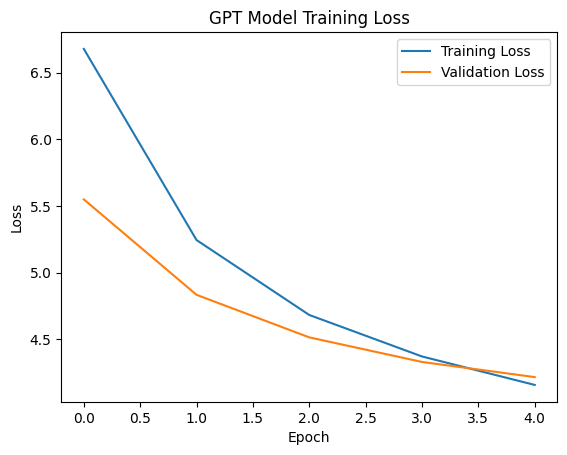

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("GPT Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Generate Text with Sampling

In [10]:
import numpy as np

def generate_text(prompt, model, tokenizer, maxlen=40, gen_tokens=20, temperature=1.0):
    input_seq = tokenizer.texts_to_sequences([prompt])
    input_seq = pad_sequences(input_seq, maxlen=maxlen-1, padding='post')

    for _ in range(gen_tokens):
        preds = model.predict(input_seq, verbose=0)[0, -1, :]
        preds = np.asarray(preds).astype('float64')

        # Apply temperature
        preds = np.log(preds + 1e-8) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        # Sample the next token
        next_token = np.random.choice(range(len(preds)), p=preds)

        # Append to sequence
        input_seq = np.append(input_seq, [[next_token]], axis=1)
        input_seq = input_seq[:, -maxlen+1:]

    # Decode the generated tokens
    generated = tokenizer.sequences_to_texts(input_seq)[0]
    return generated


In [11]:
prompt = "This wine is"
print("Temperature 1.0:\n", generate_text(prompt, model, tokenizer, temperature=1.0))
print("\nTemperature 0.5:\n", generate_text(prompt, model, tokenizer, temperature=0.5))
print("\nTemperature 1.5:\n", generate_text(prompt, model, tokenizer, temperature=1.5))


Temperature 1.0:
 <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> or crisp <OOV> <OOV> <OOV> <OOV>

Temperature 0.5:
 <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>

Temperature 1.5:
 <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> better by complex <OOV> <OOV> <OOV> <OOV> clunky to siblings on bordeaux rather now <OOV> <OOV> <OOV> of this unfold
